# 문자 단위 RNN: Char RNN
- 단어 레벨에서 문자 레벨로 변경하여 RNN을 구현하기

    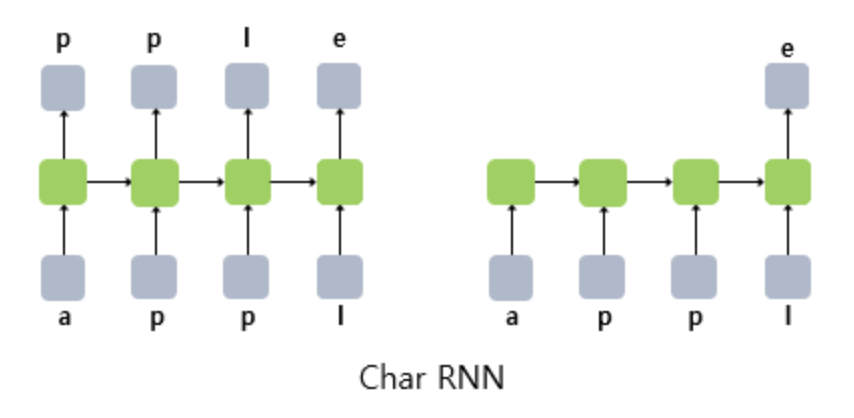

## 1. 문자 단위 RNN 언어 모델: Char RNNLM
- 문자 단위를 입,출력으로 사용하므로 임베딩층을 여기선 사용하지 않습니다.
- 다운로드 링크: http://www.gutenberg.org/files/11/11-0.txt
### 1. 데이터에 대한 이해와 전처리

In [1]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

# 데이터 로드
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

f = open('11-0.txt', 'rb')
sentences = []
for sentence in f: # 데이터로부터 한 줄씩 읽는다.
    sentence = sentence.strip() # strip()을 통해 \r, \n을 제거한다.
    sentence = sentence.lower() # 소문자화.
    sentence = sentence.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(sentence) > 0:
        sentences.append(sentence)
f.close()

In [2]:
sentences[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [3]:
total_data = ' '.join(sentences)
print('문자열의 길이 또는 총 문자의 개수: %d' % len(total_data))

문자열의 길이 또는 총 문자의 개수: 159484


In [4]:
print(total_data[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


In [5]:
char_vocab = sorted(list(set(total_data)))
vocab_size = len(char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 56


In [6]:
# 문자에 고유한 정수 부여
char_to_index = dict((char, index) for index, char in enumerate(char_vocab))
print('문자 집합 :',char_to_index)

문자 집합 : {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [7]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [8]:
# appl (입력 시퀀스) -> pple (예측해야하는 시퀀스)
train_X = 'appl'
train_y = 'pple'

In [9]:
seq_length = 60

# 문자열의 길이를 seq_length로 나누면 전처리 후 생겨날 샘플 수
n_samples = int(np.floor((len(total_data) - 1) / seq_length))
print ('샘플의 수 : {}'.format(n_samples))

샘플의 수 : 2658


In [10]:
train_X = []
train_y = []

for i in range(n_samples):
    # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 pick.
    X_sample = total_data[i * seq_length: (i + 1) * seq_length]

    # 정수 인코딩
    X_encoded = [char_to_index[c] for c in X_sample]
    train_X.append(X_encoded)

    # 오른쪽으로 1칸 쉬프트
    y_sample = total_data[i * seq_length + 1: (i + 1) * seq_length + 1]
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [11]:
print('X 데이터의 첫번째 샘플 :',train_X[0])
print('y 데이터의 첫번째 샘플 :',train_y[0])
print('-'*50)
print('X 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_X[0]])
print('y 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_y[0]])

X 데이터의 첫번째 샘플 : [49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]
y 데이터의 첫번째 샘플 : [37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]
--------------------------------------------------
X 데이터의 첫번째 샘플 디코딩 : ['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 'a', 'l', 'i', 'c', 'e', 's', ' ', 'a', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'e', 's', ' ', 'i', 'n', ' ', 'w', 'o', 'n', 'd', 'e', 'r', 'l', 'a']
y 데이터의 첫번째 샘플 디코딩 : ['h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e',

In [12]:
print(train_X[1])

[43, 33, 10, 0, 31, 54, 0, 41, 34, 52, 38, 48, 0, 32, 30, 47, 47, 44, 41, 41, 0, 49, 37, 38, 48, 0, 34, 31, 44, 44, 40, 0, 38, 48, 0, 35, 44, 47, 0, 49, 37, 34, 0, 50, 48, 34, 0, 44, 35, 0, 30, 43, 54, 44, 43, 34, 0, 30, 43, 54]


In [13]:
print(train_y[1])

[33, 10, 0, 31, 54, 0, 41, 34, 52, 38, 48, 0, 32, 30, 47, 47, 44, 41, 41, 0, 49, 37, 38, 48, 0, 34, 31, 44, 44, 40, 0, 38, 48, 0, 35, 44, 47, 0, 49, 37, 34, 0, 50, 48, 34, 0, 44, 35, 0, 30, 43, 54, 44, 43, 34, 0, 30, 43, 54, 52]


In [14]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (2658, 60, 56)
train_y의 크기(shape) : (2658, 60, 56)


### 2. 모델 설계하기

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
84/84 - 14s - loss: 3.0733 - accuracy: 0.1821 - 14s/epoch - 166ms/step
Epoch 2/80
84/84 - 16s - loss: 2.6991 - accuracy: 0.2554 - 16s/epoch - 188ms/step
Epoch 3/80
84/84 - 21s - loss: 2.3457 - accuracy: 0.3391 - 21s/epoch - 246ms/step
Epoch 4/80
84/84 - 18s - loss: 2.1986 - accuracy: 0.3739 - 18s/epoch - 219ms/step
Epoch 5/80
84/84 - 17s - loss: 2.0925 - accuracy: 0.4001 - 17s/epoch - 206ms/step
Epoch 6/80
84/84 - 20s - loss: 2.0058 - accuracy: 0.4213 - 20s/epoch - 234ms/step
Epoch 7/80
84/84 - 19s - loss: 1.9325 - accuracy: 0.4401 - 19s/epoch - 228ms/step
Epoch 8/80
84/84 - 18s - loss: 1.8711 - accuracy: 0.4573 - 18s/epoch - 213ms/step
Epoch 9/80
84/84 - 18s - loss: 1.8144 - accuracy: 0.4735 - 18s/epoch - 218ms/step
Epoch 10/80
84/84 - 20s - loss: 1.7659 - accuracy: 0.4864 - 20s/epoch - 233ms/step
Epoch 11/80
84/84 - 19s - loss: 1.7236 - accuracy: 0.4974 - 19s/epoch - 228ms/step
Epoch 12/80
84/84 - 18s - loss: 1.6772 - accuracy: 0.5097 - 18s/epoch - 216ms/step
Epoch 13/80
8

In [16]:
def sentence_generation(model, length):
    # 문자에 대한 랜덤한 정수 생성
    ix = [np.random.randint(vocab_size)]

    # 랜덤한 정수로부터 맵핑되는 문자 생성
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1],'번 문자',y_char[-1],'로 예측을 시작!')

    # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성
    X = np.zeros((1, length, vocab_size))

    for i in range(length):
        # X[0][i][예측한 문자의 인덱스] = 1, 즉, 예측 문자를 다음 입력 시퀀스에 추가
        X[0][i][ix[-1]] = 1
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [17]:
result = sentence_generation(model, 100)
print(result)

47 번 문자 r 로 예측을 시작!
1/1 [==============================] - 0s 27ms/step
r feet, for it flashed across her mind the large begures. clatced all three little mouse to be beat c


## 2. 문자 단위 RNN으로 텍스트 생성하기
### 1. 데이터에 대한 이해와 전처리

In [18]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [19]:
raw_text = '''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [20]:
tokens = raw_text.split()
raw_text = ' '.join(tokens)
print(raw_text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [21]:
# 중복을 제거한 문자 집합 생성
char_vocab = sorted(list(set(raw_text)))
vocab_size = len(char_vocab)
print('문자 집합 :',char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합 : [' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
문자 집합의 크기 : 33


In [22]:
char_to_index = dict((char, index) for index, char in enumerate(char_vocab)) # 문자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [23]:
length = 11
sequences = []
for i in range(length, len(raw_text)):
    seq = raw_text[i-length:i] # 길이 11의 문자열을 지속적으로 만든다.
    sequences.append(seq)
print('총 훈련 샘플의 수: %d' % len(sequences))

총 훈련 샘플의 수: 426


In [24]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [25]:
encoded_sequences = []
for sequence in sequences: # 전체 데이터에서 문장 샘플을 1개씩 꺼낸다.
    encoded_sequence = [char_to_index[char] for char in sequence] # 문장 샘플에서 각 문자에 대해서 정수 인코딩을 수행.
    encoded_sequences.append(encoded_sequence)

In [26]:
encoded_sequences[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]]

In [27]:
encoded_sequences = np.array(encoded_sequences)

# 맨 마지막 위치의 문자를 분리
X_data = encoded_sequences[:,:-1]
# 맨 마지막 위치의 문자를 저장
y_data = encoded_sequences[:,-1]

In [28]:
print(X_data[:5])
print(y_data[:5])

[[ 8  0 16 14 28  0 24 23  0 31]
 [ 0 16 14 28  0 24 23  0 31 18]
 [16 14 28  0 24 23  0 31 18 28]
 [14 28  0 24 23  0 31 18 28 17]
 [28  0 24 23  0 31 18 28 17  0]]
[18 28 17  0 21]


In [29]:
# 원-핫 인코딩
X_data_one_hot = [to_categorical(encoded, num_classes=vocab_size) for encoded in X_data]
X_data_one_hot = np.array(X_data_one_hot)
y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)

In [30]:
print(X_data_one_hot.shape)

(426, 10, 33)


## 모델 설계하기

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

hidden_units = 64

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_data_one_hot.shape[1], X_data_one_hot.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_data_one_hot, y_data_one_hot, epochs=100, verbose=2)

Epoch 1/100
14/14 - 1s - loss: 3.4726 - accuracy: 0.1385 - 989ms/epoch - 71ms/step
Epoch 2/100
14/14 - 0s - loss: 3.3692 - accuracy: 0.1972 - 69ms/epoch - 5ms/step
Epoch 3/100
14/14 - 0s - loss: 3.1067 - accuracy: 0.1972 - 73ms/epoch - 5ms/step
Epoch 4/100
14/14 - 0s - loss: 3.0130 - accuracy: 0.1972 - 60ms/epoch - 4ms/step
Epoch 5/100
14/14 - 0s - loss: 2.9523 - accuracy: 0.1972 - 63ms/epoch - 5ms/step
Epoch 6/100
14/14 - 0s - loss: 2.9318 - accuracy: 0.1972 - 62ms/epoch - 4ms/step
Epoch 7/100
14/14 - 0s - loss: 2.9115 - accuracy: 0.1972 - 74ms/epoch - 5ms/step
Epoch 8/100
14/14 - 0s - loss: 2.8873 - accuracy: 0.1972 - 77ms/epoch - 6ms/step
Epoch 9/100
14/14 - 0s - loss: 2.8709 - accuracy: 0.1972 - 82ms/epoch - 6ms/step
Epoch 10/100
14/14 - 0s - loss: 2.8443 - accuracy: 0.1972 - 73ms/epoch - 5ms/step
Epoch 11/100
14/14 - 0s - loss: 2.8132 - accuracy: 0.1972 - 73ms/epoch - 5ms/step
Epoch 12/100
14/14 - 0s - loss: 2.7791 - accuracy: 0.1995 - 73ms/epoch - 5ms/step
Epoch 13/100
14/14 - 0s

In [32]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):

    # 초기 시퀀스
    init_text = seed_text
    sentence = ''

    # 다음 문자 예측은 총 n번만 반복.
    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 문자)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for char, index in char_to_index.items():
            if index == result:
                break

        # 현재 시퀀스 + 예측 문자를 현재 시퀀스로 변경
        seed_text = seed_text + char

        # 예측 문자를 문장에 저장
        sentence = sentence + char

    # n번의 다음 문자 예측이 끝나면 최종 완성된 문장을 리턴.
    sentence = init_text + sentence
    return sentence

In [33]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to use words abort beer. But when I stao ty tya
